In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [4]:
ls

3scene@  highway_a836030.jpg  Untitled0.ipynb


In [5]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from imutils import paths
import numpy as np
import os

In [6]:
print("[INFO] loading images...")
imagePaths = paths.list_images("3scene")
data = []
labels = []

[INFO] loading images...


In [7]:
for imagePath in imagePaths:
	# load the input image from disk, resize it to 64x64 pixels, scale
	# the pixel intensities to the range [0, 1], and then update our
	# images list
	image = Image.open(imagePath)
	image = np.array(image.resize((64, 64))) / 255.0
	data.append(image)

	# extract the class label from the file path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

In [8]:
print(labels)

['forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest', 'forest',

In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [10]:
(trainX, testX, trainY, testY) = train_test_split(np.array(data),	np.array(labels), test_size=0.25)
print(trainX.shape)
print(testX.shape)

(711, 64, 64, 3)
(237, 64, 64, 3)


In [11]:
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization

In [12]:
from keras.layers import Dropout
base_model = MobileNet(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
out = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_______________________________________________________

In [13]:
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   mode='auto',
                   restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weight_scene_mobileNet.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',)

In [14]:
from keras.models import Sequential
from keras.layers.core import Flatten
from keras.layers.core import Dense

model = Sequential(
    [
        Flatten(input_shape=(64*64*3,)),
        Dense(100, activation="relu", name="layer1"),
        Dense(16, activation="relu", name="layer2"),
        Dense(16, activation="relu", name="layer3"),
        Dense(3, activation = "softmax", name="layer4"),
    ]
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               1228900   
_________________________________________________________________
layer2 (Dense)               (None, 16)                1616      
_________________________________________________________________
layer3 (Dense)               (None, 16)                272       
_________________________________________________________________
layer4 (Dense)               (None, 3)                 51        
Total params: 1,230,839
Trainable params: 1,230,839
Non-trainable params: 0
_________________________________________________________________


In [16]:
print("[INFO] training network...")
opt = Adam(lr=1e-3, decay=1e-3 / 50)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=32, callbacks=[es, checkpoint])

[INFO] training network...
Epoch 1/50
19/23 [=======================>......] - ETA: 0s - loss: 1.0919 - accuracy: 0.4359WARNING:tensorflow:Model was constructed with shape (None, 12288) for input Tensor("flatten_input:0", shape=(None, 12288), dtype=float32), but it was called on an input with incompatible shape (None, 64, 64, 3).

Epoch 00001: val_accuracy improved from -inf to 0.48101, saving model to best_weight_scene_mobileNet.h5
23/23 [==============================] - 1s 22ms/step - loss: 1.0881 - accuracy: 0.4346 - val_loss: 0.9487 - val_accuracy: 0.4810
Epoch 2/50
18/23 [======================>.......] - ETA: 0s - loss: 0.9693 - accuracy: 0.5330
Epoch 00002: val_accuracy improved from 0.48101 to 0.52321, saving model to best_weight_scene_mobileNet.h5
23/23 [==============================] - 0s 14ms/step - loss: 0.9481 - accuracy: 0.5443 - val_loss: 0.9027 - val_accuracy: 0.5232
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.8460 - accuracy: 0.6006
Epoch 00

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


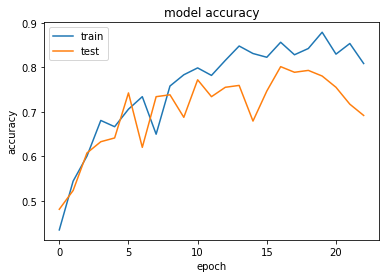

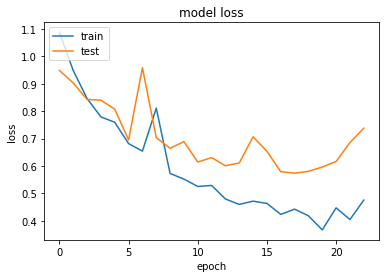

In [17]:
import matplotlib.pyplot as plt

print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:


# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))



[INFO] evaluating network...
              precision    recall  f1-score   support

       coast       0.82      0.78      0.80        98
      forest       0.83      0.79      0.81        76
     highway       0.71      0.81      0.76        63

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.79      0.79      0.79       237



In [19]:
model.save('nnmodel_scene')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: nnmodel_scene/assets


In [20]:
import cv2
import matplotlib.pyplot as plt
image1='highway_a836030.jpg'

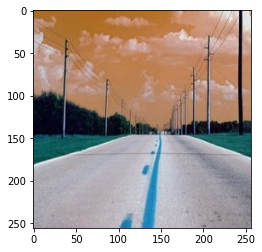

In [21]:
img_array = cv2.imread(image1)
plt.imshow(img_array)
plt.show()

In [24]:


image_testing = Image.open('highway_a836030.jpg')
image_testing = np.array(image_testing.resize((64, 64))) / 255.0
image_testing.shape



(64, 64, 3)

In [25]:
image_testing = np.expand_dims(image_testing, axis=0)
print(image_testing.shape)

(1, 64, 64, 3)


In [26]:


output = model.predict(image_testing, 1)
print(output)
print(lb.classes_[output.argmax(axis=1)])



[[0.03973459 0.00993585 0.9503295 ]]
['highway']
